<a href="https://colab.research.google.com/github/xuebingwu/predict-splice-sites/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Xuebing Wu lab @ Columbia](https://xuebingwu.github.io/)  |     [GitHub repository](https://github.com/xuebingwu/splice-site-prediction-with-pangolin) 

# <font color='MediumSlateBlue '> Predict 5' and 3' splice sites from a single sequence using [Pangolin](https://doi.org/10.1186/s13059-022-02664-4)</font> 



OUTPUT


2023-01-04 04:15:58: Input sequence length = 3456
2023-01-04 04:15:58: Loading models
2023-01-04 04:15:59: Scoring sites: + strand
2023-01-04 04:16:00: Filtering sites: + strand
2023-01-04 04:16:00: Saving to file: + strand
2023-01-04 04:16:00: Plotting sites: + strand



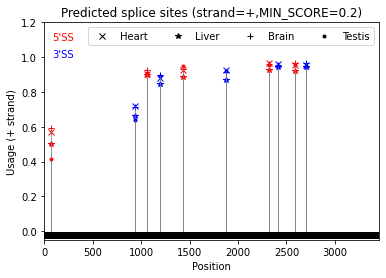



2023-01-04 04:16:00: Scoring sites: - strand
2023-01-04 04:16:01: Filtering sites: - strand

No sites found on the - strand with MIN_SCORE = 0.2

---------------------------------
#Predicted splice sites
#Options: BOTH_STRANDS=True, MODEL_TYPE=Usage, MIN_SCORE=0.2
#Columns info:
#1 - Position: site position in the sequence
#2 - Strand: strand of the site
#3 - Sequence: 20-nt junction sequence. Intron-lower case; Exon-upper case
#4 - Type: 5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical
#5-8 - Scores: site usage or P(splice) in each tissue

Position	Strand	Sequence	Type	Heart	Liver	Brain	Testis
73	+	CCCGCCGCCAGgtaagcccg	5'SS	0.57	0.503	0.59	0.415
934	+	attctcgcagCTCACCATGG	3'SS	0.72	0.66	0.711	0.64
1062	+	CCAGGCACCAGgtaggggag	5'SS	0.906	0.897	0.926	0.909
1197	+	tccttcccagGGCGTGATGG	3'SS	0.88	0.845	0.898	0.892
1436	+	AGATGACCCAGgtgagtggc	5'SS	0.927	0.888	0.93	0.947
1878	+	tgccttacagATCATGTTTG	3'SS	0.924	0.871	0.912	0.921
2316	+	TTCCTTCCTGGgtgagtgga	5'SS	0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
##@title Analyze your sequence

# scripts from custom_usage.py from the Pangolin package

import os
from matplotlib import pylab
import matplotlib.lines as mlines
from google.colab import files
import datetime
import re


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

########## input 
SEQUENCE = "Enter your sequence or select a sample sequence (default: ACTB pre-mRNA)"#@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter"] {allow-input: true}

#@markdown - To run: click `Runtime` -> `Run all` in the menu bar, or click the triangle play/run button on the left
#@markdown - Input format: raw sequence (A/C/G/T/U only); can paste a multi-line sequence from a FASTA file (without the header) 
#@markdown - More accurate to use full-length transcript sequence (model scores each 10kb window)
#@markdown - Can also run on a short sequence 

seq = SEQUENCE

if seq == "ACTB pre-mRNA":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
elif seq == "GAPDH pre-mRNA":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
elif seq == "EGFP + CENPB 3' UTR reporter":
  seq = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAAGTCACTGGACCTAGCTGTGCCCCCAACCTAGATTGGCAGCACCACCCCAGGGCAGAGGACTCTCTGGGCACCCGCTGTGCATGGAGCCAGAGTGCAGAGCCCCAGATCCTTTAGTAATGCTTCCCCTGGTCCTGCAACAGGCCCGGTCACCTCGGCCGGGCCCGGGGCTGAGGTCAGCCTCACTGCCTGCTTATTGCCTCTTTCTCAGAATCCTCTTTCCTCCCCATTTGGCCCTGGGCTCAGGGGACCAGGTGGGGCGGGTGGGGAGCTGTCCGGTGCTACCACACCGTGCCCTCAGTGGACTAACCACAGCAGCAGCCAGGGATGGGCCCTGGAGGTTCCCGGCCGGAGAGTGCCTCTCCCCTCTGCCATCCACGTCAGGTCTTTGGTGGGGGGACCCCAAAGCCATTCTGGGAAGGGCTCCAGAAGAAGGTCCAGCCTAGGCCCCCTGCAAGGCTGGCAGCCCCCACCCCCACCCCCCAGGCCGCCTTGAGAAGCACAGTTTAACTCACTGCGGGCTCCTGAGCCTGCTTCTGCCTGCTTTCCACCTCCCCAGTCCCTTTCTCTGGCCCTGTCCATGTGACTTTGGCCCTTGGTTTTCTTTCCAGATTGGAGGTTTCCAAGAGGCCCCCCACCGTGGAAGTAACCAAGGGCGCTTCCTTGTGGGCAGCTGCAGGCCCCATGCCTCTCCTCCCTCTCTGGCAGGGCCCCATCCTGGGCAGAGGGGCCTGGGGCTGGGCCCAGAGTCCAGCCGTCCAGCTGCTCCTTTCCCAGTTTGATTTCAATAAATCTGTCCACTCCCCTTTTGTGGGGGTGAACGTTTTAACAGCCAAGGGT"
elif seq == "Enter your sequence or select a sample sequence (default: ACTB pre-mRNA)":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
else: # user input 
  # clean up sequence: upper case, remove space, RNA->DNA
  seq = seq.upper().replace('U','T').replace(' ','')
  # if contains non ACGT letters:
  if not all(char in 'ACGT' for char in seq):
    print("\n\n")
    print('\n'+ bcolors.BOLD +bcolors.FAIL + "WARNING: Your sequence contains non A/C/G/T letters!"+bcolors.ENDC)
    L0  = len(seq)
    seq = re.sub('[^ACGT]+', '', seq)
    L1 = len(seq)
    print(L0-L1,'non A/C/G/T base(s) removed!'+bcolors.ENDC)
    exit()


print('\n\n'+ bcolors.BOLD +bcolors.OKBLUE + "OUTPUT"  +bcolors.ENDC)

######### options

BOTH_STRANDS = True #@param {type:"boolean"}
#@markdown - Also find splice sites on the reverse complement strand 
#@markdown - Useful for analyzing splicing on plasmid sequences


# set model type
MODEL_TYPE = "Usage" #@param ["Usage", "P(splice)"]
#@markdown - *Usage*: predict tissue-specific usage of a splice site (default)
#@markdown - *P(splice)*: predict tissue-specific probability of a site being spliced

if MODEL_TYPE == "Usage":
  model_nums = [1,3,5,7]
else:
  model_nums = [0,2,4,6]
# 0 = Heart, P(splice)
# 1 = Heart, usage
# 2 = Liver, P(splice)
# 3 = Liver, usage
# 4 = Brain, P(splice)
# 5 = Brain, usage
# 6 = Testis, P(splice)
# 7 = Testis, usage

tissues = ['Heart','Liver','Brain','Testis']


# min score
MIN_SCORE = 0.2 #@param {type:"slider", min:0.01, max:1, step:0.01}
#@markdown - Minimum usage/strength of a site to be included in the output 

if not os.path.exists("predict-splice-sites"):
  print("\n")
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Loading Pangolin (~30s, first time only)')
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  #!pip install pyvcf gffutils biopython pandas pyfastx
  !git clone https://github.com/xuebingwu/predict-splice-sites.git
  %cd predict-splice-sites
  !pip install .
  %cd /content
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

from pkg_resources import resource_filename
from pangolin.model import *

# Load models
def load_models(model_nums):
    models = []
    for i in model_nums:
        for j in range(1, 6):
            model = Pangolin(L, W, AR)
            if torch.cuda.is_available():
                model.cuda()
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)))
            else:
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)),
                                     map_location=torch.device('cpu'))
            model.load_state_dict(weights)
            model.eval()
            models.append(model)
    return models

IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
INDEX_MAP = {0:1, 1:2, 2:4, 3:5, 4:7, 5:8, 6:10, 7:11}

def reverse_complement(seq):
    comp = {'A':'T','C':'G','G':'C','T':'A'}
    seq2 = ''
    for i in range(len(seq)):
      seq2 += comp[seq[i]]
    return seq2[::-1]

def one_hot_encode(seq):
    '''
    one hot enencode of a dna sequence
    '''
    # replace space
    seq = seq.replace(' ','')
    seq = seq.upper().replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    seq = np.asarray(list(map(int, list(seq))))
    return IN_MAP[seq.astype('int8')]

def run_models(seq):
    '''
    run Pangolin models on an input sequence seq
    
    input:
      seq     - a sequence
    
    output:
      scores  - a list of arrays, each array is a tissue,
              - each element in the array is the score for a nucleotide
    '''

    seq = one_hot_encode(seq).T
    seq = torch.from_numpy(np.expand_dims(seq, axis=0)).float()

    if torch.cuda.is_available():
        seq = seq.to(torch.device("cuda"))

    scores = []
    for j, model_num in enumerate(model_nums):
        score = []
        # Average across 5 models
        for model in models[5*j:5*j+5]:
            with torch.no_grad():
                score.append(model(seq)[0][INDEX_MAP[model_num],:].cpu().numpy())
        scores.append(np.mean(score, axis=0))
    return scores

def filter_predicted_sites(seq,scores,min_score):
    # filter sites based on max score across 4 tissues
    # annotate whether a site is 5'SS or 3'SS
    # note that Pangolin does not train 5'SS/3'SS separately

    # output: sites
    #   - a dictionary from position to site info
    #   - e.g. 
    #     53:"TGCGTCGCCAGgtgaagacg	5'SS	0.803,0.78,0.826,0.712"

    sites = {}
    for i in range(len(seq)):
        # filter based on max score in 4 tissues
        if scores[0][i] >= min_score or scores[1][i] >= min_score or scores[2][i] >= min_score or scores[3][i] >= min_score:
            if i<10:
                sites[i+1] = '.'*(10-i)+seq[:i+10]
            elif i+10 > len(seq):
                sites[i+1] = seq[i-10:]+'.'*(i+10-len(seq))
            else:
                sites[i+1] = seq[i-10:i+10]
            # determine splice site type
            if seq[i+1:i+3] == 'GT' and seq[i-2:i] != 'AG':
                # 5'SS: GT but not AG
                sites[i+1] = sites[i+1][:11].upper()+sites[i+1][11:].lower()
                sites[i+1] = sites[i+1] + "\t5'SS"
            elif seq[i+1:i+3] != 'GT' and seq[i-2:i] == 'AG':
                # 3'SS: AG but not GT
                sites[i+1] = sites[i+1][:10].lower()+sites[i+1][10:].upper()
                sites[i+1] = sites[i+1] + "\t3'SS"
            elif seq[i+1:i+3] == 'GT' and seq[i-2:i] == 'AG':
                # very rarely, has both GT and AG
                sites[i+1] = sites[i+1] + '\tUndetermined'
            else:
                # very rarely, no GT or AG
                sites[i+1] = sites[i+1] + '\tNoncanonical'
            sites[i+1] = sites[i+1] + '\t'+ ','.join([str(round(scores[0][i],3)),str(round(scores[1][i],3)),str(round(scores[2][i],3)),str(round(scores[3][i],3))]) 
    return sites

# plot sites
def plot_sites(sites,strand):
  # sites - filtered splice sites

  # setup the plot
  pylab.plot()
  pylab.xlim(0,SEQ_LEN)
  pylab.ylim(-0.05,1.2)
  pylab.title('Predicted splice sites (strand='+strand+',MIN_SCORE='+str(MIN_SCORE)+')')
  pylab.ylabel(MODEL_TYPE+' ('+strand+' strand)')
  pylab.xlabel('Position')

  # legend/text for site type
  colors = {"5'SS":'red',"3'SS":'blue',"Undetermined":'green',"Noncanonical":'gray'}
  pylab.text(SEQ_LEN/40,1.1, "5'SS", color='red')
  pylab.text(SEQ_LEN/40,1.0,  "3'SS", color='blue')

  # legend for tissue
  markers = ['x','*','+','.']
  legend_handles = []
  for i in range(4):
    legend_handles.append(mlines.Line2D([], [], color='black', marker=markers[i], linestyle='None',
                           label=tissues[i]))
  pylab.legend(handles=legend_handles,ncol=4)

  # a thick line at the bottom to represent the entire input sequence
  pylab.plot([0,SEQ_LEN],[-0.02,-0.02],linewidth=7,c='black')

  # plot each site
  for pos in sites:
    x = int(pos)
    if strand == '-':
      x = SEQ_LEN - x
    site_seq, site_type, site_score = sites[pos].split('\t')
    site_scores = site_score.split(',')
    for i in range(4):
      # a marker
      pylab.plot(x,float(site_scores[i]),markers[i],c=colors[site_type])
      # a vertical line
      pylab.plot([x,x],[0,float(site_scores[i])],linewidth=0.5,c='gray')

  # save as pdf
  pylab.savefig('predicted_splice_sites'+strand+'.pdf')  
  pylab.show()

def site_table(sites,strand):
  # text/table output
  if strand == '+':
    outf = open("predicted_splice_sites.txt",'w')
    outf.write("#Predicted splice sites\n")
    outf.write("#Options: BOTH_STRANDS="+str(BOTH_STRANDS)+", MODEL_TYPE="+MODEL_TYPE+", MIN_SCORE="+str(MIN_SCORE)+"\n")
    outf.write("#Columns info:\n")
    outf.write("#1 - Position: site position in the sequence\n")
    outf.write("#2 - Strand: strand of the site\n")
    outf.write("#3 - Sequence: 20-nt junction sequence. Intron-lower case; Exon-upper case\n")
    outf.write("#4 - Type: 5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical\n")
    outf.write("#5-8 - Scores: site usage or P(splice) in each tissue\n\n")
    outf.write('\t'.join(['Position','Strand','Sequence','Type'])+'\t'+'\t'.join(tissues)+'\n')
    for pos in sites:
      outf.write(str(pos)+'\t+\t'+sites[pos].replace(',','\t')+'\n')  
  else:
    outf = open("predicted_splice_sites.txt",'a+')
    for pos in sites:
      outf.write(str(SEQ_LEN-pos)+'\t-\t'+sites[pos].replace(',','\t')+'\n')
  outf.close()

## start the analysis

SEQ_LEN = len(seq)

print("\n")

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Input sequence length =',SEQ_LEN)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Loading models')
#load models
models = load_models(model_nums)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Scoring sites: + strand')
# score sequences
scores = run_models( 5000*'N'+ seq + 5000*'N')

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Filtering sites: + strand')
sites = filter_predicted_sites(seq,scores,MIN_SCORE)

# delete output files from a previous run
os.system('rm *.pdf *.txt *.zip')

if len(sites) == 0:
  print('\n'+ bcolors.BOLD +bcolors.FAIL + "No sites found on the + strand with MIN_SCORE = "+str(MIN_SCORE)+bcolors.ENDC)
else:
  # write sites to a file
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Saving to file: + strand')
  site_table(sites,'+')

  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Plotting sites: + strand\n')
  plot_sites(sites,'+')


# reverse complement strand
if BOTH_STRANDS:
  seq = reverse_complement(seq)
  print("\n")
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Scoring sites: - strand')
  scores_rc = run_models( 5000*'N'+ seq + 5000*'N')
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Filtering sites: - strand')
  sites_rc  = filter_predicted_sites(seq,scores_rc,MIN_SCORE)
  if len(sites_rc) == 0:
    print('\n'+ bcolors.BOLD +bcolors.FAIL + "No sites found on the - strand with MIN_SCORE = "+str(MIN_SCORE)+bcolors.ENDC)
  else:
    print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Saving to file: - strand')
    site_table(sites_rc,'-')
    print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Plotting sites: - strand\n')
    plot_sites(sites_rc,'-')

# print out predicted sites
print("\n---------------------------------")
with open('predicted_splice_sites.txt','r') as f:
  for line in f:
    print(line.strip())

os.system(f'zip res.zip *.pdf *.txt')
files.download(f"res.zip")